In [1]:
# HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
%matplotlib inline

sns.set()
sns.set_context('talk')
pd.options.display.max_rows = 7
pd.options.display.max_columns = 7
np.set_printoptions(precision=2, suppress=True)

In [2]:
# HIDDEN
from scipy.optimize import minimize as sci_min

def minimize(cost_fn, grad_cost_fn, X, y, progress=True):
    '''
    Uses scipy.minimize to minimize cost_fn using a form of gradient descent.
    '''
    theta = np.zeros(X.shape[1])
    iters = 0
    
    def objective(theta):
        return cost_fn(theta, X, y)
    def gradient(theta):
        return grad_cost_fn(theta, X, y)
    def print_theta(theta):
        nonlocal iters
        if progress and iters % progress == 0:
            print(f'theta: {theta} | cost: {cost_fn(theta, X, y):.2f}')
        iters += 1
        
    print_theta(theta)
    return sci_min(
        objective, theta, method='BFGS', jac=gradient, callback=print_theta,
        tol=1e-7
    ).x

## Linear Regression Case Study

In this section, we perform an end-to-end case study of applying the linear regression model to a dataset. The dataset we will be working with has various attributes, such as length and girth, of donkeys.

Our task is to predict a donkey's weight using linear regression.

## Preliminary Data Overview

We will begin by reading in the dataset and taking a quick peek at its contents.

In [3]:
donkeys = pd.read_csv("donkeys.csv")
donkeys.head()

,BCS,Age,Sex,...,Height,Weight,WeightAlt
0,3.0,<2,stallion,...,90,77,NaN
1,2.5,<2,stallion,...,94,100,NaN
2,1.5,<2,stallion,...,95,74,NaN
3,3.0,<2,female,...,96,116,NaN
4,2.5,<2,female,...,91,91,NaN


Now, we will look at how large our dataset is.

It's always a good idea to look at _how much_ data we have by looking at the dimensions of the dataset. An example of how this might be useful: if our data has a large number of observations, it would not be a good idea to print out the whole dataframe.

In [4]:
donkeys.shape

(544, 8)

The dataset is relatively small, with only 544 rows of observations and 8 columns. Let's look at what columns we have available to us.

In [5]:
donkeys.columns.values

array(['BCS', 'Age', 'Sex', 'Length', 'Girth', 'Height', 'Weight',
       'WeightAlt'], dtype=object)

Our analysis can be guided by a good understanding of our data, so we should aim to understand what each of these columns represent. A few of these columns are self-explanatory, but others require a little more explanation:

- `BCS`: Body Condition Score (a physical health rating)
- `Girth`: the measurement around the middle of the donkey
- `WeightAlt`: 31 donkeys in our data were weighed twice in order to check the accuracy of the scale. The second weighing is in `WeightAlt`.

It is also a good idea to determine which of our variables are quantitative and which are categorical.

Quantitative: `Length`, `Girth`, `Height`, `Weight`, `WeightAlt`

Categorical: `BCS`, `Age`, `Sex`


## Data Cleaning

In this section, we will check the data for any abnormalities that we have to deal with.

By examining `WeightAlt` more closely, we can make sure that the scale is accurate by taking the difference between the two different weighings and plotting them.

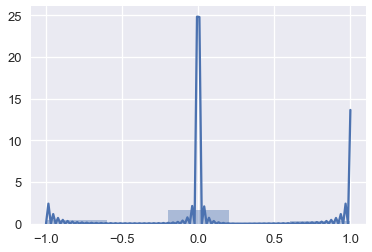

In [6]:
difference = donkeys['WeightAlt'] - donkeys['Weight']
sns.distplot(difference.dropna());

The measurements are all within 1 kg of each other, which seems reasonable.

Next, we can look for unusual values that might indicate errors or other problems. We can use the quantile function in order to detect anomalous values.

In [7]:
donkeys.quantile([0.005, 0.995])

,BCS,Length,Girth,Height,Weight,WeightAlt
0.005,1.5,71.145,90.000,89.0,71.715,98.75
0.995,4.0,111.000,131.285,112.0,214.000,192.80


For each of these numerical columns, we can look at which rows fall outside of these quantiles and what values they take on. Consider that we want our model to apply to only healthy and mature donkeys.

First, let's look at the `BCS` column.

In [8]:
donkeys[(donkeys['BCS'] < 1.5) | (donkeys['BCS'] > 4)]['BCS']

291    4.5
445    1.0
Name: BCS, dtype: float64

Also looking at the barplot of `BCS`:

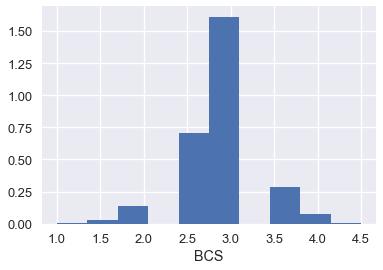

In [9]:
plt.hist(donkeys['BCS'], normed=True)
plt.xlabel('BCS');

Considering that `BCS` is an indication of the health of a donkey, a `BCS` of 1 represents an extremely emaciated donkey and a `BCS` of 4.5 an overweight donkey. Also looking at the barplot, there only appear to be two donkeys with such outlier `BCS` values. Thus, it would probably be a good idea to remove these two donkeys.

---

Now, let's look at `Length`, `Girth`, and `Height`.

In [10]:
donkeys[(donkeys['Length'] < 71.145) | (donkeys['Length'] > 111)]['Length']

8       46
22      68
26      69
216    112
Name: Length, dtype: int64

In [11]:
donkeys[(donkeys['Girth'] < 90) | (donkeys['Girth'] > 131.285)]['Girth']

8       66
239    132
283    134
523    134
Name: Girth, dtype: int64

In [12]:
donkeys[(donkeys['Height'] < 89) | (donkeys['Height'] > 112)]['Height']

8       71
22      86
244    113
523    116
Name: Height, dtype: int64

For these three columns, the donkey in row 8 seems to have a much smaller value than the cut-off while the other anomalous donkeys are close to the cut-off and likely do not need to be removed.

---

Finally, let's take a look at `Weight`.

In [13]:
donkeys[(donkeys['Weight'] < 71.715) | (donkeys['Weight'] > 214)]['Weight']

8       27
26      65
50      71
291    227
523    230
Name: Weight, dtype: int64

The first 2 and last 2 donkeys in the list are far off from the cut-off and most likely should be removed. The middle donkey can be included.

---

Since `WeightAlt` closely corresponds to `Weight`, we do not have to check this column for anomalies. Summarizing what we have learned, here is how we want to filter our donkeys:

- Keep donkeys with `BCS` in the range 1.5 and 4
- Keep donkeys with `Weight` between 71 and 214  


In [14]:
donkeys_c = donkeys[(donkeys['BCS'] >= 1.5) & (donkeys['BCS'] <= 4) &
                         (donkeys['Weight'] >= 71) & (donkeys['Weight'] <= 214)]

## Train-Test Split

Before we proceed with our data analysis, we divide our data into an 80/20 split, using 80% of our data to train our model and setting aside the other 20% for evaluation of the model.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(donkeys_c.drop(['Weight'], axis=1),
                                                    donkeys_c['Weight'],
                                                    test_size=0.2,
                                                   random_state=42)
X_train.shape, X_test.shape

((431, 7), (108, 7))

Let's also create a function that evaluates our predictions on the test set. Recall that our metric for linear regression is mean-squared error. 

In [16]:
def mse_test_set(predictions):
    return float(np.sum((predictions - y_test) ** 2))

## Exploring the Data + Data Visualization

As in any data science project, we will explore our data before attempting to fit a model to it.

First, we will examine the categorical variables with boxplots.

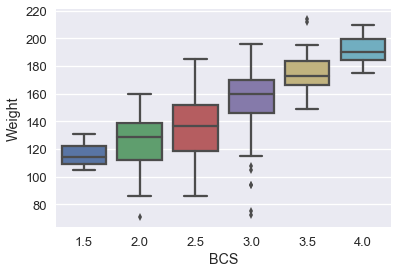

In [17]:
# HIDDEN
sns.boxplot(x=X_train['BCS'], y=y_train);

It seems like median weight increases with BCS, but not linearly.

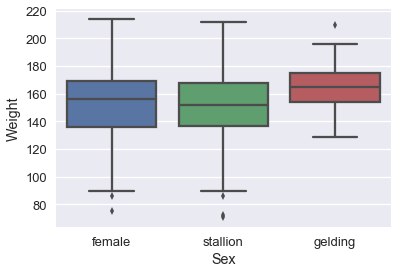

In [18]:
# HIDDEN
sns.boxplot(x=X_train['Sex'], y=y_train,
            order = ['female', 'stallion', 'gelding']);

It seems like the sex of the donkey doesn't appear to cause much of a difference in weight.

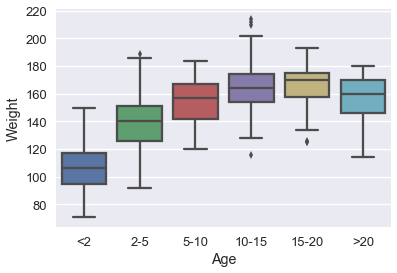

In [19]:
# HIDDEN
sns.boxplot(x=X_train['Age'], y=y_train, 
            order = ['<2', '2-5', '5-10', '10-15', '15-20', '>20']);

For donkeys over 5, the weight distribution is not too different.

Now, let's look at the quantitative variables. We can plot each of them against the target variable.

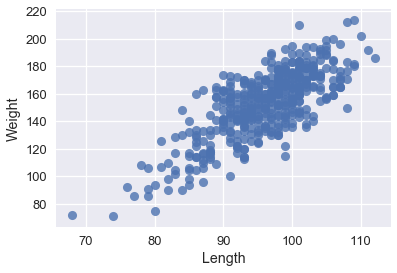

In [20]:
# HIDDEN
X_train['Weight'] = y_train
sns.regplot('Length', 'Weight', X_train, fit_reg=False);

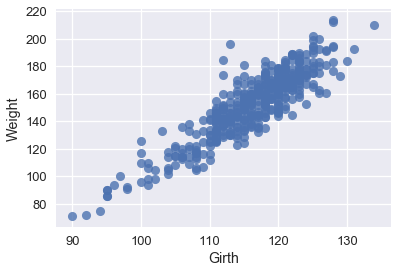

In [21]:
# HIDDEN
sns.regplot('Girth', 'Weight', X_train, fit_reg=False);

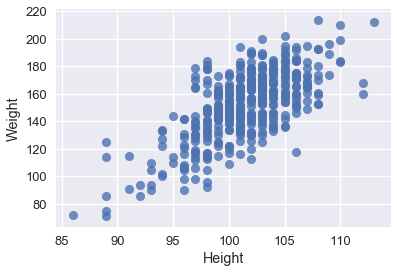

In [22]:
# HIDDEN
sns.regplot('Height', 'Weight', X_train, fit_reg=False);

All three of our quantitative features have a linear relationship with our target variable of `Weight`, so we will not have to perform any transformations on our input data.

It is also a good idea to see if our features are linear with each other. We plot two below: 

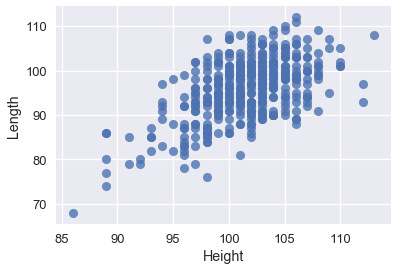

In [23]:
# HIDDEN
sns.regplot('Height', 'Length', X_train, fit_reg=False);

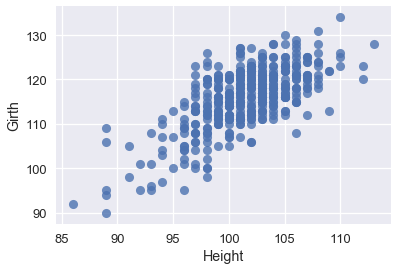

In [24]:
# HIDDEN
sns.regplot('Height', 'Girth', X_train, fit_reg=False);

From these plots, we can see that our predictor variables also have strong linear relationships with each other. This makes our model harder to interpret, so we should keep this in mind after we create our model.

## Simpler Linear Models

Rather than using all of our data at once, let's try to fit linear models to one or two variables first. 

Below are three simple linear regression models using just one quantitative variable. Which model appears to be the best?

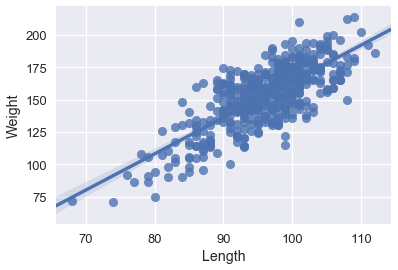

In [25]:
# HIDDEN
sns.regplot('Length', 'Weight', X_train, fit_reg=True);

In [26]:
# HIDDEN
model = LinearRegression()
model.fit(X_train[['Length']], X_train['Weight'])
predictions = model.predict(X_test[['Length']])
print("MSE:", mse_test_set(predictions))

MSE: 26052.580077025486


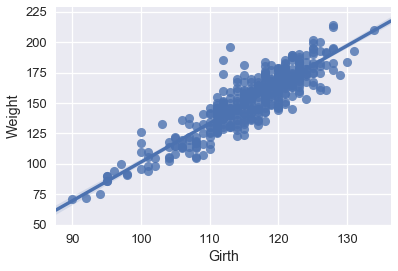

In [27]:
sns.regplot('Girth', 'Weight', X_train, fit_reg=True);

In [28]:
# HIDDEN
model = LinearRegression()
model.fit(X_train[['Girth']], X_train['Weight'])
predictions = model.predict(X_test[['Girth']])
print("MSE:", mse_test_set(predictions))

MSE: 13248.81410593239


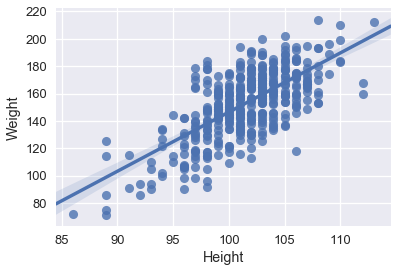

In [29]:
sns.regplot('Height', 'Weight', X_train, fit_reg=True);

In [30]:
# HIDDEN
model = LinearRegression()
model.fit(X_train[['Height']], X_train['Weight'])
predictions = model.predict(X_test[['Height']])
print("MSE:", mse_test_set(predictions))

MSE: 36343.308584306156


Looking at the scatterplots and the mean-squared errors, it seems like `Girth` is the best sole predictor of `Weight` as it has the strongest linear relationship with `Weight` and the smallest mean-squared error.

Can we do better with two variables? Let's try fitting a linear model using both `Girth` and `Length`. Although it is not as easy to visualize this model, we can still look at the MSE of this model.

In [31]:
# HIDDEN
model = LinearRegression()
model.fit(X_train[['Girth', 'Length']], X_train['Weight'])
predictions = model.predict(X_test[['Girth', 'Length']])
print("MSE:", mse_test_set(predictions))

MSE: 9680.90242337725


Wow! Looks like our MSE went down from around 13000 with just `Girth` alone to 10000 with `Girth` and `Length`. Using two variables has improved our model.

We can also use categorical variables in our model. Let's now look at a linear model using the categorical variable of `Age`. This is the plot of `Age` versus `Weight`:

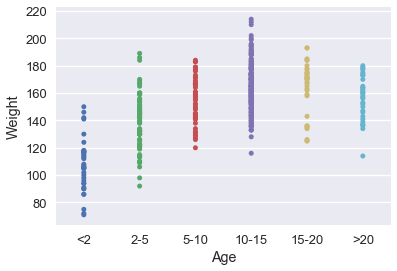

In [32]:
# HIDDEN
sns.stripplot(x='Age', y='Weight', data=X_train, order=['<2', '2-5', '5-10', '10-15', '15-20', '>20']);

Seeing how `Age` is a categorical variable, we need to introduce dummy variables in order to produce a linear regression model.

In [33]:
# HIDDEN
just_age_and_weight = X_train[['Age', 'Weight']]
with_age_dummies = pd.get_dummies(just_age_and_weight, columns=['Age'])
model = LinearRegression()
model.fit(with_age_dummies.drop('Weight', axis=1), with_age_dummies['Weight'])

just_age_and_weight_test = X_test[['Age']]
with_age_dummies_test = pd.get_dummies(just_age_and_weight_test, columns=['Age'])
predictions = model.predict(with_age_dummies_test)
print("MSE:", mse_test_set(predictions))

MSE: 41511.58282277702


A MSE of around 40000 is worse than what we could get using any single one of the quantitative variables, but this variable could still prove to be useful in our linear model.

Let's try to interpret this linear model. Note that every donkey that falls into an age category, say 2-5 years of age, will receive the same prediction because they share the input values: a 1 in the column corresponding to 2-5 years of age, and 0 in all other columns. Thus, we can interpret categorical variables as simply changing the constant in the model because the categorical variable separates the donkeys into groups and gives one prediction for all donkeys within that group.

Our next step is to create a final model using both our categorical variables and multiple quantitative variables.

## Transforming Variables

Recall from our boxplots that `Sex` was not a useful variable, so we will drop it. We will also remove the `WeightAlt` column because we only have its value for 31 donkeys. Finally, using `get_dummies`, we transform the categorical variables `BCS` and `Age` into dummy variables so that we can include them in the model. 

In [34]:
# HIDDEN
X_train = X_train.drop('Weight', axis=1)

In [35]:
# HIDDEN
pd.set_option('max_columns', 15)

In [36]:
donkeys_train = X_train.drop(['Sex', 'WeightAlt'], axis=1)
donkeys_train = pd.get_dummies(donkeys_train, columns=['BCS', 'Age'])
donkeys_train.head()

,Length,Girth,Height,BCS_1.5,BCS_2.0,BCS_2.5,BCS_3.0,BCS_3.5,BCS_4.0,Age_10-15,Age_15-20,Age_2-5,Age_5-10,Age_<2,Age_>20
465,98,113,99,0,0,0,1,0,0,0,0,1,0,0,0
233,101,119,101,0,0,0,1,0,0,1,0,0,0,0,0
450,106,125,103,0,0,1,0,0,0,1,0,0,0,0,0
453,93,120,100,0,0,1,0,0,0,0,0,1,0,0,0
452,98,120,108,0,0,1,0,0,0,0,0,0,1,0,0


Recall that we noticed that the weight distribution of donkeys over the age of 5 does not look very different. Thus, let's combine the columns `Age_10-15`, `Age_15-20`, and `Age_>20` into one column. 

In [37]:
age_over_10 = donkeys_train['Age_10-15'] | donkeys_train['Age_15-20'] | donkeys_train['Age_>20']
donkeys_train['Age_>10'] = age_over_10
donkeys_train = donkeys_train.drop(['Age_10-15', 'Age_15-20', 'Age_>20'], axis=1)

Since we do not want our matrix to be over-parameterized, we should drop one category from the `BCS` and `Age` dummies.

In [38]:
donkeys_train = donkeys_train.drop(['BCS_3.0', 'Age_5-10'], axis=1)
donkeys_train.head()

,Length,Girth,Height,BCS_1.5,BCS_2.0,BCS_2.5,BCS_3.5,BCS_4.0,Age_2-5,Age_<2,Age_>10
465,98,113,99,0,0,0,0,0,1,0,0
233,101,119,101,0,0,0,0,0,0,0,1
450,106,125,103,0,0,1,0,0,0,0,1
453,93,120,100,0,0,1,0,0,1,0,0
452,98,120,108,0,0,1,0,0,0,0,0


We should also add a column of biases in order to have a constant term in our model.

In [39]:
donkeys_train = donkeys_train.assign(bias=1)

In [40]:
# HIDDEN
donkeys_train = donkeys_train.reindex_axis(['bias'] + list(donkeys_train.columns[:-1]), axis=1)


In [41]:
donkeys_train.head()

,bias,Length,Girth,Height,BCS_1.5,BCS_2.0,BCS_2.5,BCS_3.5,BCS_4.0,Age_2-5,Age_<2,Age_>10
465,1,98,113,99,0,0,0,0,0,1,0,0
233,1,101,119,101,0,0,0,0,0,0,0,1
450,1,106,125,103,0,0,1,0,0,0,0,1
453,1,93,120,100,0,0,1,0,0,1,0,0
452,1,98,120,108,0,0,1,0,0,0,0,0


## Multiple Linear Regression Model

We are finally ready to fit our model to all of the variables we have deemed important and transformed into the proper form.

Our model looks like this:

$$
f_\hat{\theta} (x) = \hat{\theta_0} + \hat{\theta_1} (Length) + \hat{\theta_2} (Girth) + \hat{\theta_3} (Height) + ... +  \hat{\theta_{11}} (Age_>10)
$$

Here are the functions we defined earlier in the multiple linear regression section, which we will use again:

In [42]:
def linear_model(thetas, X):
    '''Returns predictions by a linear model on x_vals.'''
    return X @ thetas

def mse_cost(thetas, X, y):
    return np.mean((y - linear_model(thetas, X)) ** 2)

def grad_mse_cost(thetas, X, y):
    n = len(X)
    return -2 / n * (X.T @ y  - X.T @ X @ thetas)

In order to use the above functions, we need `X`, and `y`. These can both be obtained from our data frames. Remember that `X` and `y` have to be numpy matrices in order to be able to multiply them with `@` notation.

`X` consists of all columns of the data frame `donkeys_train`.

In [43]:
X = (donkeys_train
     .as_matrix())

`y` is `y_train` as a matrix.

In [44]:
y = y_train.as_matrix()

Now we just need to call the `minimize` function defined in a previous section.

In [45]:
thetas = minimize(mse_cost, grad_mse_cost, X, y)

theta: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.] | cost: 23979.72
theta: [ 0.01  0.53  0.65  0.56  0.    0.    0.    0.    0.    0.    0.    0.  ] | cost: 1214.03
theta: [-0.07  1.84  2.55 -2.87 -0.02 -0.13 -0.34  0.19  0.07 -0.22 -0.3   0.43] | cost: 1002.46
theta: [-0.25 -0.76  4.81 -3.06 -0.08 -0.38 -1.11  0.61  0.24 -0.66 -0.93  1.27] | cost: 815.50
theta: [-0.44 -0.33  4.08 -2.7  -0.14 -0.61 -1.89  1.02  0.4  -1.06 -1.57  2.09] | cost: 491.91
theta: [-1.52  0.85  2.   -1.58 -0.52 -2.22 -5.63  3.29  1.42 -2.59 -5.14  5.54] | cost: 140.86
theta: [-2.25  0.9   1.72 -1.3  -0.82 -3.52 -7.25  4.64  2.16 -2.95 -7.32  6.61] | cost: 130.33
theta: [ -4.16   0.84   1.32  -0.78  -1.65  -7.09 -10.4    7.82   4.18  -3.44
 -12.61   8.24] | cost: 116.92
theta: [ -5.89   0.75   1.17  -0.5   -2.45 -10.36 -11.81  10.04   6.08  -3.6
 -16.65   8.45] | cost: 110.37
theta: [ -7.75   0.67   1.13  -0.35  -3.38 -13.76 -11.84  11.55   8.2   -3.8  -20.
   7.55] | cost: 105.74
theta: [ -9.41   0.64   

Our linear model is:

$y = -204.03 + 0.93x_1 + ... -7.22x_{9} + 1.95x_{11}$

Let's compare this equation that we obtained to the one we would get if we had used `sklearn`'s LinearRegression model instead.

In [46]:
model = LinearRegression(fit_intercept=False) # We already accounted for it with the bias column
model.fit(X[:, :14], y)
print("Coefficients", model.coef_)

Coefficients [-204.03    0.93    1.67    0.74  -10.5    -8.72   -6.39    7.54   11.39
   -3.6    -7.22    1.95]


The coefficients look exactly the same! Our homemade functions create the same model as an established Python package!

We successfully fit a linear model to our donkey data! Nice!

## Evaluating our Model

Our next step is to evaluate our model's performance on the test set. We need to perform the same data pre-processing steps on the test set as we did on the training set before we can pass it into our model.

In [47]:
donkeys_test = X_test.drop(['Sex', 'WeightAlt'], axis=1)
donkeys_test = pd.get_dummies(donkeys_test, columns=['BCS', 'Age'])
age_over_10 = donkeys_test['Age_10-15'] | donkeys_test['Age_15-20'] | donkeys_test['Age_>20']
donkeys_test['Age_>10'] = age_over_10
donkeys_test = donkeys_test.drop(['Age_10-15', 'Age_15-20', 'Age_>20'], axis=1)
donkeys_test = donkeys_test.drop(['BCS_3.0', 'Age_5-10'], axis=1)
donkeys_test = donkeys_test.assign(bias=1)

In [48]:
# HIDDEN
donkeys_test = donkeys_test.reindex_axis(['bias'] + list(donkeys_test.columns[:-1]), axis=1)

We obtain `X` to pass into `predict` of our `LinearRegression` model:

In [49]:
X = (donkeys_test
     .as_matrix())
predictions = model.predict(X)

Let's look at the mean squared error:

In [50]:
mse_test_set(predictions)

7261.974205350595

With these predictions, we can also make a residual plot:

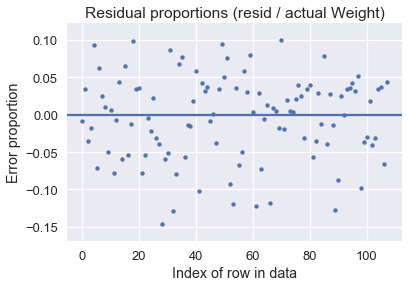

In [51]:
# HIDDEN
y = y_test.as_matrix()
resid = y - predictions
resid_prop = resid / y
plt.scatter(np.arange(len(resid_prop)), resid_prop, s=15)
plt.axhline(0)
plt.title('Residual proportions (resid / actual Weight)')
plt.xlabel('Index of row in data')
plt.ylabel('Error proportion');

Looks like our model does pretty well! The residual proportions indicate that our predictions are mostly within 15% of the correct value. 